Step 1: Import library

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_ind, levene, chi2_contingency
from semopy import Model, calc_stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [2]:
# Read data csv
df = pd.read_csv("household.csv")
df = df.drop([
    'current',
    'voltage',
    'reactive_power',
    'power_factor',
    'main',
    'description',
    'temp_min',
    'temp_max',
    'pressure',
    'speed',
    'deg',
    'temp_t+1',
    'feels_like_t+1',
], axis=1)

Step 2.2: Load data and resample to hour

In [3]:

# change date column into datetime 
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# merge data by hour (mean)
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)  
      .reset_index()
)

print("The initial columns:", len(df), "→ After merging followed by hour:", len(df_hour))
df_hour

The initial columns: 605260 → After merging followed by hour: 10234


,date,active_power,apparent_power,temp,feels_like,humidity
0,2022-11-05 14:00:00,248.780000,281.159455,24.246364,23.728182,38.436364
1,2022-11-05 15:00:00,202.663333,252.208500,24.302000,23.765333,37.366667
2,2022-11-05 16:00:00,198.863333,234.804833,24.174000,23.605833,36.666667
3,2022-11-05 17:00:00,390.181667,445.381500,23.485667,22.830667,36.083333
4,2022-11-05 18:00:00,443.036667,467.515167,21.693667,20.933333,38.783333
...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,395.692667,13.546889,12.099556,43.733333
10230,2024-01-05 20:00:00,393.211864,433.508814,11.364576,9.752203,45.779661
10231,2024-01-05 21:00:00,233.649153,265.509492,10.550508,8.994915,51.067797
10232,2024-01-05 22:00:00,374.113333,421.607833,9.260333,8.541500,50.766667


Step 2.3: Prepare some data columns

In [4]:
df_hour['electricity_consumption'] = df_hour['active_power'] / 1000 

df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)

# Lag features
df_hour['ap_lag_1h'] = df_hour['electricity_consumption'].shift(1)
df_hour['ap_lag_24h'] = df_hour['electricity_consumption'].shift(24)
df_hour['ap_roll_24h'] = df_hour['electricity_consumption'].rolling(24, min_periods=1).mean()
df_hour.dropna(inplace=True)

Step 2.4: View data

In [5]:
df_hour

,date,active_power,apparent_power,temp,feels_like,humidity,electricity_consumption,weekday,is_weekend,ap_lag_1h,ap_lag_24h,ap_roll_24h
24,2022-11-06 14:00:00,163.376667,208.594833,28.653167,27.250167,21.083333,0.163377,6,1,0.224355,0.248780,0.273721
25,2022-11-06 15:00:00,297.003333,333.192167,28.226667,26.947833,21.516667,0.297003,6,1,0.163377,0.202663,0.277652
26,2022-11-06 16:00:00,396.440000,426.028167,27.816167,26.716833,22.916667,0.396440,6,1,0.297003,0.198863,0.285884
27,2022-11-06 17:00:00,311.295000,350.784500,25.777500,25.265667,24.566667,0.311295,6,1,0.396440,0.390182,0.282597
28,2022-11-06 18:00:00,443.610000,487.643667,23.328667,22.383333,25.483333,0.443610,6,1,0.311295,0.443037,0.282621
...,...,...,...,...,...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,395.692667,13.546889,12.099556,43.733333,0.329996,4,0,0.235571,0.293395,0.241305
10230,2024-01-05 20:00:00,393.211864,433.508814,11.364576,9.752203,45.779661,0.393212,4,0,0.329996,0.342736,0.243408
10231,2024-01-05 21:00:00,233.649153,265.509492,10.550508,8.994915,51.067797,0.233649,4,0,0.393212,0.396593,0.236618
10232,2024-01-05 22:00:00,374.113333,421.607833,9.260333,8.541500,50.766667,0.374113,4,0,0.233649,0.406398,0.235273


Step 3. Implement models

Step 3.1: Descriptive statistic

=== (Descriptive Statistics) ===


,count,mean,std,min,Q1,median,Q3,max,CV(%),Skewness,Kurtosis
electricity_consumption,10112.0,0.286,0.141,0.048,0.185,0.262,0.358,0.969,49.248,1.036,1.228
temp,10112.0,19.527,6.537,-4.000,14.809,19.476,24.289,38.065,33.480,-0.063,-0.339
humidity,10112.0,47.983,19.047,1.000,32.464,47.108,62.604,100.000,39.696,0.187,-0.778


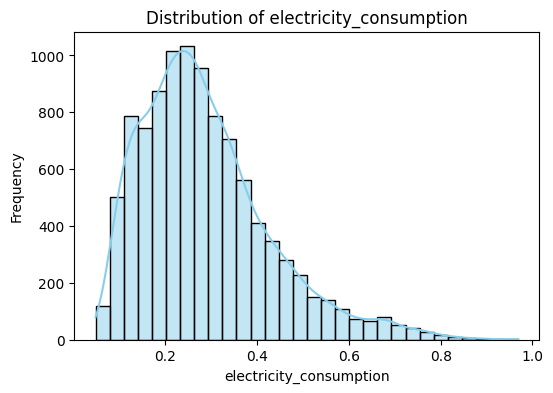

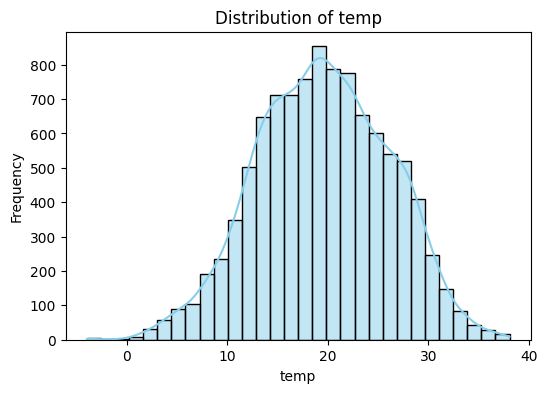

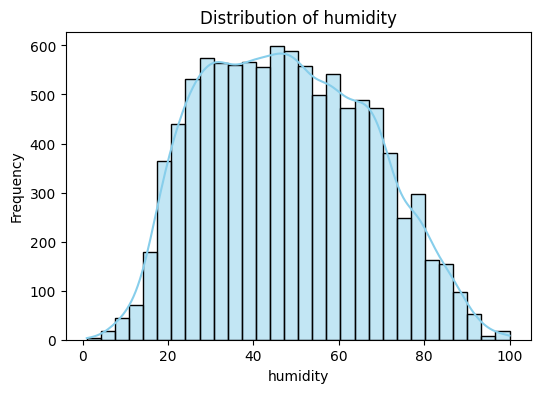

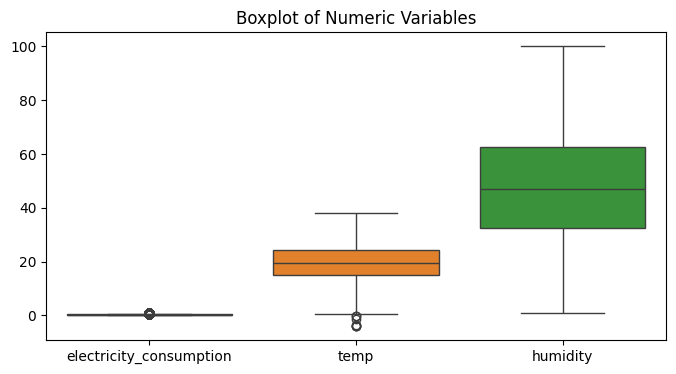

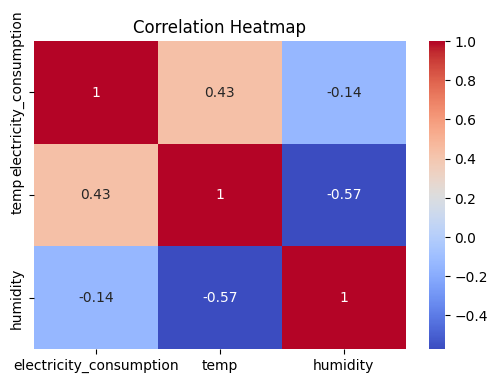

In [7]:
import numpy as np
from scipy.stats import skew, kurtosis
# Choose numeric columns for analysis
num_cols = ['electricity_consumption', 'temp', 'humidity']
num_cols = [c for c in num_cols if c in df_hour.columns]

# Create an empty DataFrame to hold the statistics
stats = pd.DataFrame(index=num_cols, columns=[
    'count', 'mean', 'std', 'min', 'Q1', 'median', 'Q3', 'max',
    'CV(%)', 'Skewness', 'Kurtosis'
])

for col in num_cols:
    data = df_hour[col].dropna()
    stats.loc[col, 'count'] = data.count()
    stats.loc[col, 'mean'] = data.mean()
    stats.loc[col, 'std'] = data.std()
    stats.loc[col, 'min'] = data.min()
    stats.loc[col, 'Q1'] = data.quantile(0.25)
    stats.loc[col, 'median'] = data.median()
    stats.loc[col, 'Q3'] = data.quantile(0.75)
    stats.loc[col, 'max'] = data.max()
    stats.loc[col, 'CV(%)'] = (data.std() / data.mean()) * 100
    stats.loc[col, 'Skewness'] = skew(data)
    stats.loc[col, 'Kurtosis'] = kurtosis(data)

# Round the statistics for better readability
stats = stats.astype(float).round(3)

# Show the descriptive statistics table
print("=== (Descriptive Statistics) ===")
display(stats)

# Data Visualization
# Histogram + KDE
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df_hour[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Boxplot
plt.figure(figsize=(8,4))
sns.boxplot(data=df_hour[num_cols])
plt.title("Boxplot of Numeric Variables")
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df_hour[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()
